In [1]:
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image
from torchinfo import summary  
import pandas as pd
from xml.dom import minidom
import csv


import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import time

from CapsuleNet_Detection import CapsuleNetwork, CapsuleLoss

In [2]:
# image_directory = 'dataset/images'
image_directory = "C:/Users/chris/Documents/GitHub/Master/Object_Localization/dataset/dataset/images"
# annotation_directory = 'dataset/annot'
annotation_directory = "C:/Users/chris/Documents/GitHub/Master/Object_Localization/dataset/dataset/annot"
h = 25
w = 25
image_size = 25

In [3]:
def extract_xml_contents(annotation_directory, image_directory):

    file = minidom.parse(annotation_directory)

    #Get image hight and width
    height, width = cv2.imread(image_directory).shape[:2]

    #Get bounding box coordinates

    xmin = file.getElementsByTagName('xmin')
    #xmax[0] greift auf das erste gefundene xmax-Element in der Liste zu. 
    # .firstChild verweist auf den ersten untergeordneten Knoten des xmax-Elements. In XML-Dateien ist dies in der Regel der Textknoten, der den eigentlichen Wert enthält.
    #.data liest den Textinhalt dieses Knotens aus, der hier den Wert von xmax als Zeichenkette darstellt
    x1 = float(xmin[0].firstChild.data)

    ymin = file.getElementsByTagName('ymin')
    y1 = float(ymin[0].firstChild.data)

    xmax = file.getElementsByTagName('xmax')
    x2 = float(xmax[0].firstChild.data)

    ymax = file.getElementsByTagName('ymax')
    y2 = float(ymax[0].firstChild.data)

    class_name = file.getElementsByTagName('name')

    if class_name[0].firstChild.data == 'cat':
        class_num = 0
    else:
        class_num= 1

    files = file.getElementsByTagName('filename')
    filename = files[0].firstChild.data 

    return filename, width, height, class_num, x1, y1, x2, y2

In [4]:
numbers_to_labels={0: 'cat', 1:'dog'}


In [5]:
# Function to convert XML files to CSV
def xml_to_csv():
    xml_list=[]

    # Get each file in the image and annotation directory
    annotation_files = os.listdir(annotation_directory)
    image_files = os.listdir(image_directory)
  # zip erstell paare
    for annotation, image in zip(annotation_files, image_files):

        annotation_path=os.path.join(annotation_directory, annotation)

        image_path = os.path.join(image_directory, image)

        value =  extract_xml_contents(annotation_path, image_path)

        xml_list.append(value)

      # Columns for Pandas DataFrame
    column_name = ['filename', 'width', 'height', 'class_num', 'xmin', 'ymin', 'xmax', 'ymax']

      # Create the DataFrame from mat_list
    xml_df = pd.DataFrame(xml_list, columns=column_name)

    # Return the dataframe
    return xml_df

In [6]:
# The Classes we will use for our training
classes_list = sorted(['cat',  'dog'])

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df = xml_to_csv()

labels_df

,filename,width,height,class_num,xmin,ymin,xmax,ymax
0,cat.0.jpg,256,256,0,55.358205,10.992091,197.387579,171.245211
1,cat.1.jpg,256,256,0,49.572895,24.298304,256.000000,256.000000
2,cat.10.jpg,256,256,0,10.232775,26.033898,256.000000,256.000000
3,cat.100.jpg,256,256,0,29.035035,10.413560,233.545772,256.000000
4,cat.101.jpg,256,256,0,16.885880,10.702824,256.000000,256.000000
...,...,...,...,...,...,...,...,...
1195,dog.9076.jpg,256,256,1,43.859883,29.649718,135.954802,86.851982
1196,dog.9077.jpg,256,256,1,64.903955,20.827121,200.677966,256.000000
1197,dog.9078.jpg,256,256,1,66.061021,20.537854,199.123168,235.462151
1198,dog.9079.jpg,256,256,1,3.290398,4.338983,256.000000,244.790960


In [7]:
# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('dataset.csv'), index=None)

In [8]:
def preprocess_dataset():

    labels = []
    boxes = []
    img_list = []



    with open('dataset.csv') as csvfile:
        rows = csv.reader(csvfile)
       # Skip header row
        next(rows)

        for row in rows:
            labels.append(int(row[3]))#

            #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size, 256 here.
            arr = [float(row[4])/image_size,  
                float(row[5])/image_size,
                float(row[6])/image_size,
                float(row[7])/image_size]
            boxes.append(arr)
            img_path = row[0]
            # Read the image
            img  = cv2.imread(os.path.join(image_directory,img_path),cv2.IMREAD_GRAYSCALE)
            
            

            # Resize all images to a fix size
            image = cv2.resize(img, (h, w))

                    # # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
            

            # Normalize the image by dividing it by 255.0 
            image = image.astype("float") / 255.0

            # Append it to the list of images
            img_list.append(image)

    return labels, boxes, img_list





In [9]:
# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
img_list[0].shape


(25, 25)

In [10]:
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)




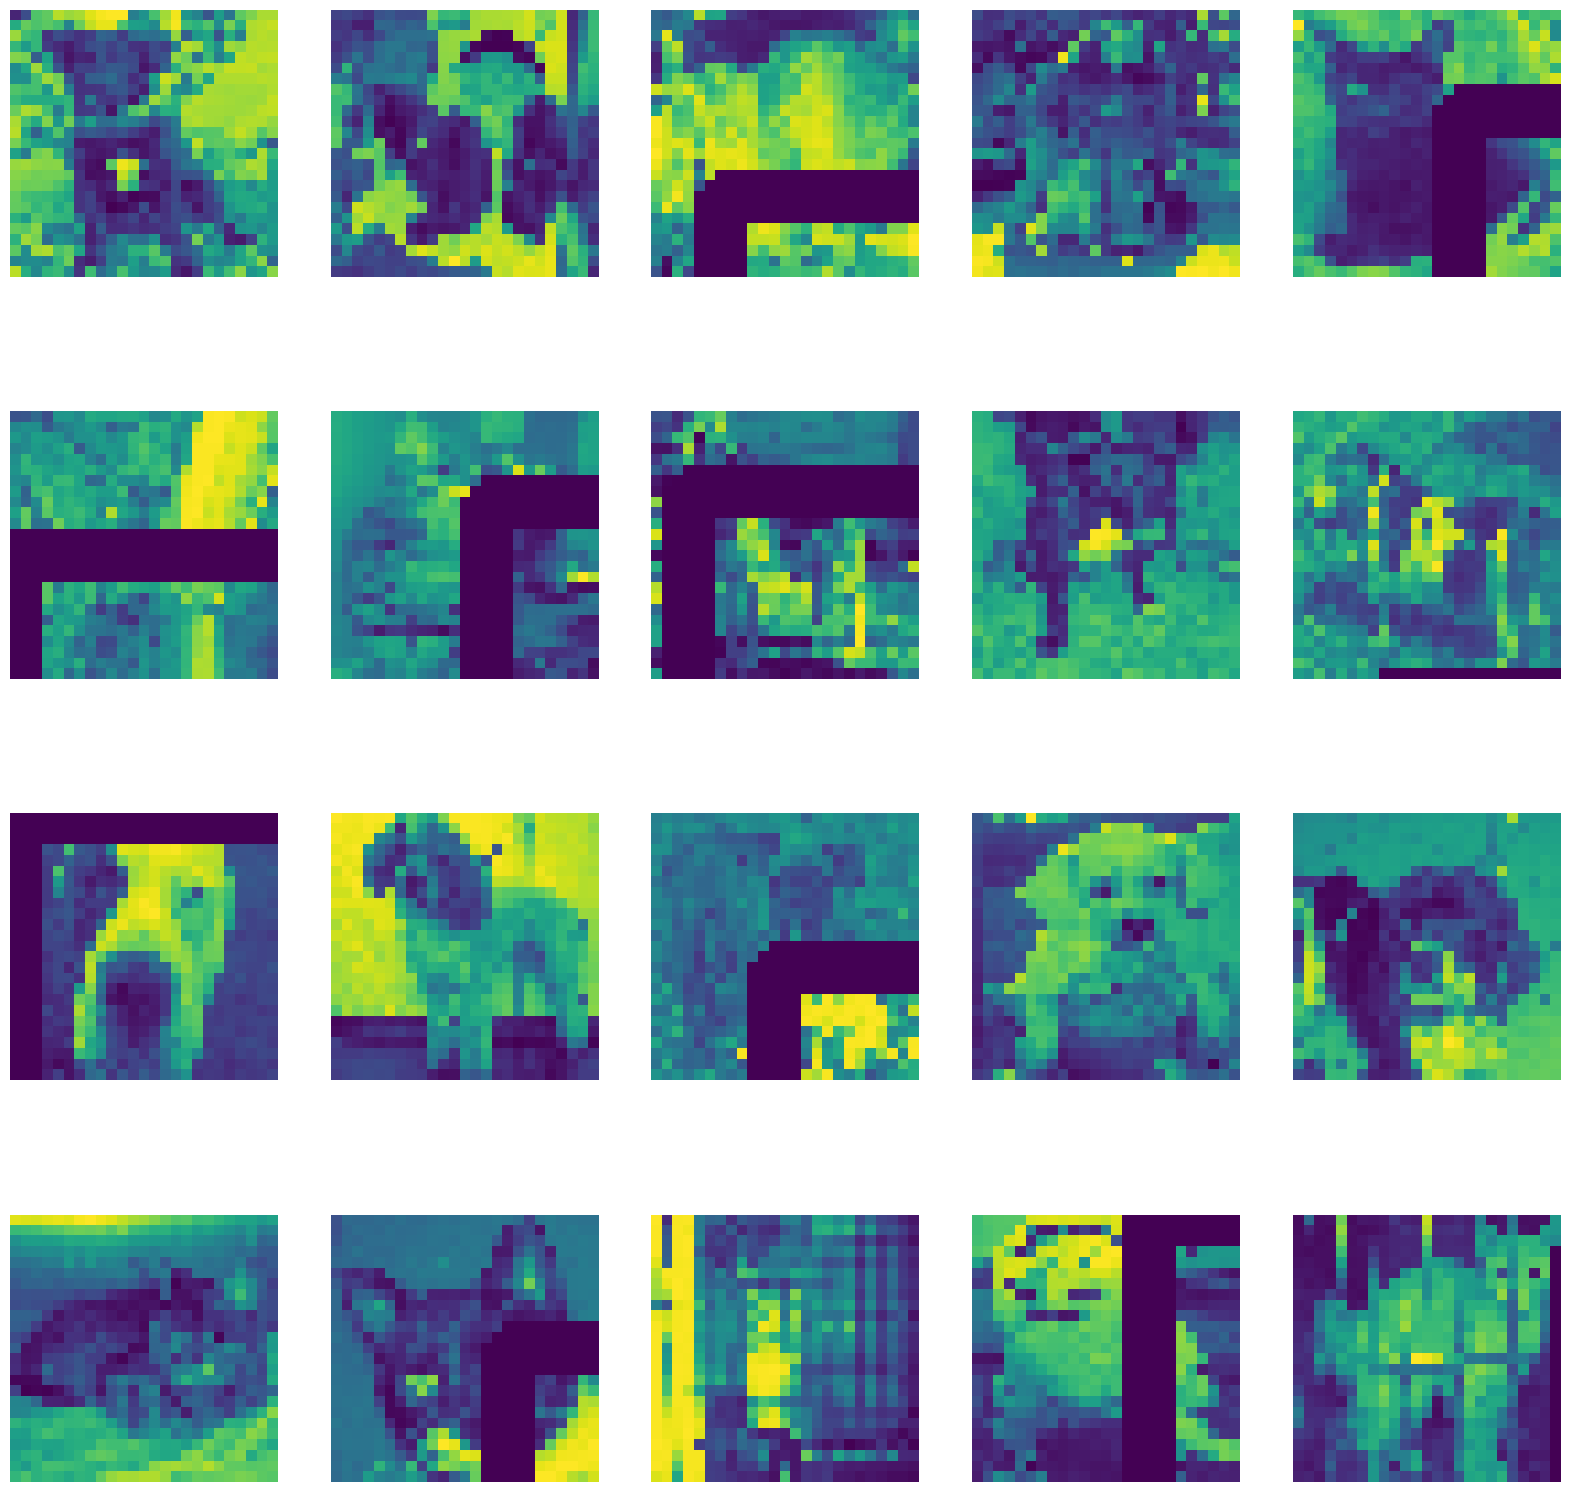

In [11]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for itr, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i]

    # Rescaling the boundig box values to match the image size
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3)
    
    # Clip the values to 0-1 and draw the sample of images
    img = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, itr)
    plt.imshow(img)
    plt.axis('off')

In [12]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split(np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 960, Validation Images Count: 240


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        
        #This reordering is needed because PyTorch expects image tensors in the format [batch, channels, height, width],
        #while many other libraries (like NumPy) store images in [batch, height, width, channels] format.
        # (960, 256, 256, 3) --> (960 3 256 256)
        self.images = torch.from_numpy(train_images).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.images[idx],
                self.labels[idx],
                self.boxes[idx]
                )
    
class ValDataset(Dataset):
    def __init__(self, val_images, val_labels, val_boxes):
        self.images = torch.from_numpy(val_images).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [15]:


dataset = Dataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=2)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t),dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

In [17]:
model = CapsuleNetwork(image_size=image_size)
model = model.to(device)
model

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_label_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=625, bias=True)
      (5): Sigmoid()
    )
    (linear_boxes_layers): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=4, bias=True)
      (3): Sigmoid()
    )
  )
)

In [ ]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (class_fc2): Linear(in_features=240, out_features=120, bias=True)
  (class_out): Linear(in_features=120, out_features=2, bias=True)
  (box_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (box_fc2): Linear(in_features=240, out_features=120, bias=True)
  (box_out): Linear(in_features=120, out_features=4, bias=True)
)

In [24]:
summary(model=model,   
        input_size=(8, 3, 256, 256), # (batch_size, color_channels, height, width)  
        col_names=["input_size", "output_size", "num_params"],  
        col_width=20,  
        row_settings=["var_names"] 
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [18]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [19]:
dataloader = torch.utils.data.DataLoader(
       dataset, batch_size=2, shuffle=True)

valdataloader = torch.utils.data.DataLoader(
       valdataset, batch_size=2, shuffle=True)


In [20]:

# Durchlaufe den ersten Batch
for images, labels, boxes in dataloader:
    print("Images batch shape:", images.shape)  # Ausgabe der Bilddaten-Form (Batchgröße, Kanäle, Höhe, Breite)
    print("Labels batch shape:", labels.shape)  # Ausgabe der Label-Form (Batchgröße)
    print("Labels:", labels)                    # Ausgabe der Labels
    print("First image in batch:", images[0])   # Anzeige des ersten Bildes im Batch
    break  # Nur den ersten Batch anzeigen, Schleife abbrechen

Images batch shape: torch.Size([2, 25, 25])
Labels batch shape: torch.Size([2])
Labels: tensor([0, 1])
First image in batch: tensor([[0.1608, 0.1647, 0.1804, 0.1961, 0.2275, 0.2314, 0.2471, 0.2667, 0.2824,
         0.3059, 0.3255, 0.3412, 0.3647, 0.5098, 0.5020, 0.4980, 0.4980, 0.4824,
         0.4706, 0.4667, 0.4627, 0.4431, 0.4314, 0.4196, 0.4118],
        [0.1686, 0.1725, 0.1922, 0.2118, 0.3020, 0.2392, 0.2627, 0.2667, 0.2824,
         0.3098, 0.3255, 0.3451, 0.3686, 0.5059, 0.5059, 0.4980, 0.5020, 0.4824,
         0.4784, 0.4627, 0.4510, 0.4471, 0.4353, 0.4275, 0.4157],
        [0.1882, 0.2000, 0.2275, 0.2392, 0.4627, 0.4745, 0.2863, 0.2824, 0.2902,
         0.3176, 0.3333, 0.3490, 0.3804, 0.5137, 0.5176, 0.5098, 0.4549, 0.4784,
         0.4314, 0.4314, 0.4078, 0.4471, 0.4431, 0.4275, 0.4157],
        [0.1647, 0.1765, 0.2431, 0.3765, 0.4706, 0.5333, 0.3098, 0.5333, 0.3098,
         0.3098, 0.3294, 0.3490, 0.3843, 0.5255, 0.5176, 0.5137, 0.4549, 0.4353,
         0.2745, 0.3373, 0.43

In [ ]:
def train(model):
    criterion = CapsuleLoss()
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.001)
    num_of_epochs = 3
    epochs = []
    losses = []
    # Creating a directory for storing models
    # os.mkdir('models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (images, labels, boxes) in enumerate(dataloader):
        	# Converting data from cpu to GPU if available to improve speed
            images = images[:,np.newaxis, :]
            images, labels, boxes = images.to(device),labels.to(device),boxes.to(device)
            
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [label_preds,reconstructions,y,box_preds]= model(images)
            # Compute loss (here CrossEntropyLoss)
            class_loss = criterion(label_preds, y, images, reconstructions)
            box_loss = F.mse_loss(box_preds, boxes)
            (box_loss + class_loss).backward()
            # class_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        model.eval()
        for batch, (images, labels, boxes) in enumerate(valdataloader):
            images = images[:,np.newaxis, :]
        	# Converting data from cpu to GPU if available to improve speed	
            images, labels, boxes = images.to(device),labels.to(device),boxes.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [label_preds,reconstructions,y,box_preds]= model(images)
                
                # Compute loss (here CrossEntropyLoss)
                class_loss = criterion(label_preds, y, images, reconstructions)
                box_loss = F.mse_loss(box_preds, boxes)
                # Compute loss (here CrossEntropyLoss)

            tot_loss += (class_loss.item() + box_loss.item())
            # print(label_preds)
            # print("-----")
            # print(label_preds.shape)
            tot_correct += get_num_correct(torch.sum(label_preds, dim=-1), labels)
            print("Val batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/2.4, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        # torch.save(model.state_dict(), "model_ep"+str(epoch+1)+".pth")

In [30]:
train(model)

tensor([[[-0.0849,  0.0496,  0.3714, -0.2834, -0.0542,  0.0889, -0.3950,
           0.1282,  0.1826,  0.1041, -0.2574,  0.2537, -0.0795,  0.0889,
           0.0388, -0.0126],
         [-0.0148,  0.0125, -0.0019, -0.0076, -0.0029,  0.0081, -0.0056,
           0.0062, -0.0062,  0.0015,  0.0031,  0.0088,  0.0104,  0.0016,
           0.0150, -0.0083]],

        [[-0.0850,  0.0498,  0.3715, -0.2802, -0.0553,  0.0892, -0.3949,
           0.1289,  0.1811,  0.1046, -0.2555,  0.2543, -0.0793,  0.0887,
           0.0387, -0.0136],
         [-0.0149,  0.0124, -0.0020, -0.0075, -0.0032,  0.0081, -0.0055,
           0.0063, -0.0062,  0.0015,  0.0030,  0.0087,  0.0102,  0.0015,
           0.0154, -0.0082]]], device='cuda:0')
-----
torch.Size([2, 2, 16])
tensor([[[-0.0819,  0.0504,  0.3644, -0.2739, -0.0549,  0.0878, -0.3860,
           0.1272,  0.1807,  0.1013, -0.2475,  0.2464, -0.0773,  0.0881,
           0.0407, -0.0131],
         [-0.0142,  0.0120, -0.0016, -0.0073, -0.0032,  0.0079, -0.0058,
  